# Problem Introduction

## Dataset Description

### Appliances Energy Prediction Dataset

The **Appliances Energy Prediction Dataset** consists of **19,735 time-series measurements**, collected at **10-minute intervals** over approximately **4.5 months** in a low-energy smart home. Each observation includes **28 features** derived from environmental sensors, energy meters, and external weather stations.

#### 📌 Features Overview

- **Indoor conditions (continuous):**  
  - **Temperatures (°C):** `T1` to `T9` (e.g., kitchen, living room, bathroom, bedrooms, outside north wall, etc.)  
  - **Humidity (%):** `RH_1` to `RH_9` (same locations as temperature sensors)  

- **Weather station variables (continuous):**  
  - `T_out` (outdoor temperature), `RH_out` (outdoor humidity), `Press_mm_hg` (pressure),  
    `Windspeed`, `Visibility`, `Tdewpoint` (dew point temperature)

- **Other numerical variables (continuous):**  
  - `lights` (energy usage in Wh), `rv1`, `rv2` (non-dimensional random variables)

- **Target variable (continuous):**  
  - `Appliances` (energy consumption in Wh)

#### 🛠️ Data Characteristics

- No missing values
- Measurements collected via ZigBee sensors and M‑Bus energy meters
- Weather data merged from Chievres Airport (Belgium)
- Dataset donated in February 2017
- Introduced and analyzed in a study by Candanedo et al. (2017)
- Commonly used for regression-based energy forecasting and time-series modeling

**Source:** [UCI Machine Learning Repository - Appliances Energy Prediction](https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction)

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import torch
import torch.nn as nn
import joblib
from joblib import dump, load


from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from torch.utils.data import DataLoader, TensorDataset
import random
from data.make_dataset import load_dataset

RANDOM_SEED = 18

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

df = load_dataset()

# EDA

## Data Cleaning

In [7]:
# Drop the date column (non-numeric, not useful for modeling)
#date = X.drop(columns=['date'])

# X = X.drop(columns=['date'])
feature_names = df.columns

# Check for missing values or NaNs
missing_values = df.isnull().sum()
nan_values = df.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])
print("\nNaN values per column:\n", nan_values[nan_values > 0])

# If needed: drop or impute missing values (not required here if no NaNs found)
# Example (only if needed): X = X.dropna()

Missing values per column:
 Series([], dtype: int64)

NaN values per column:
 Series([], dtype: int64)


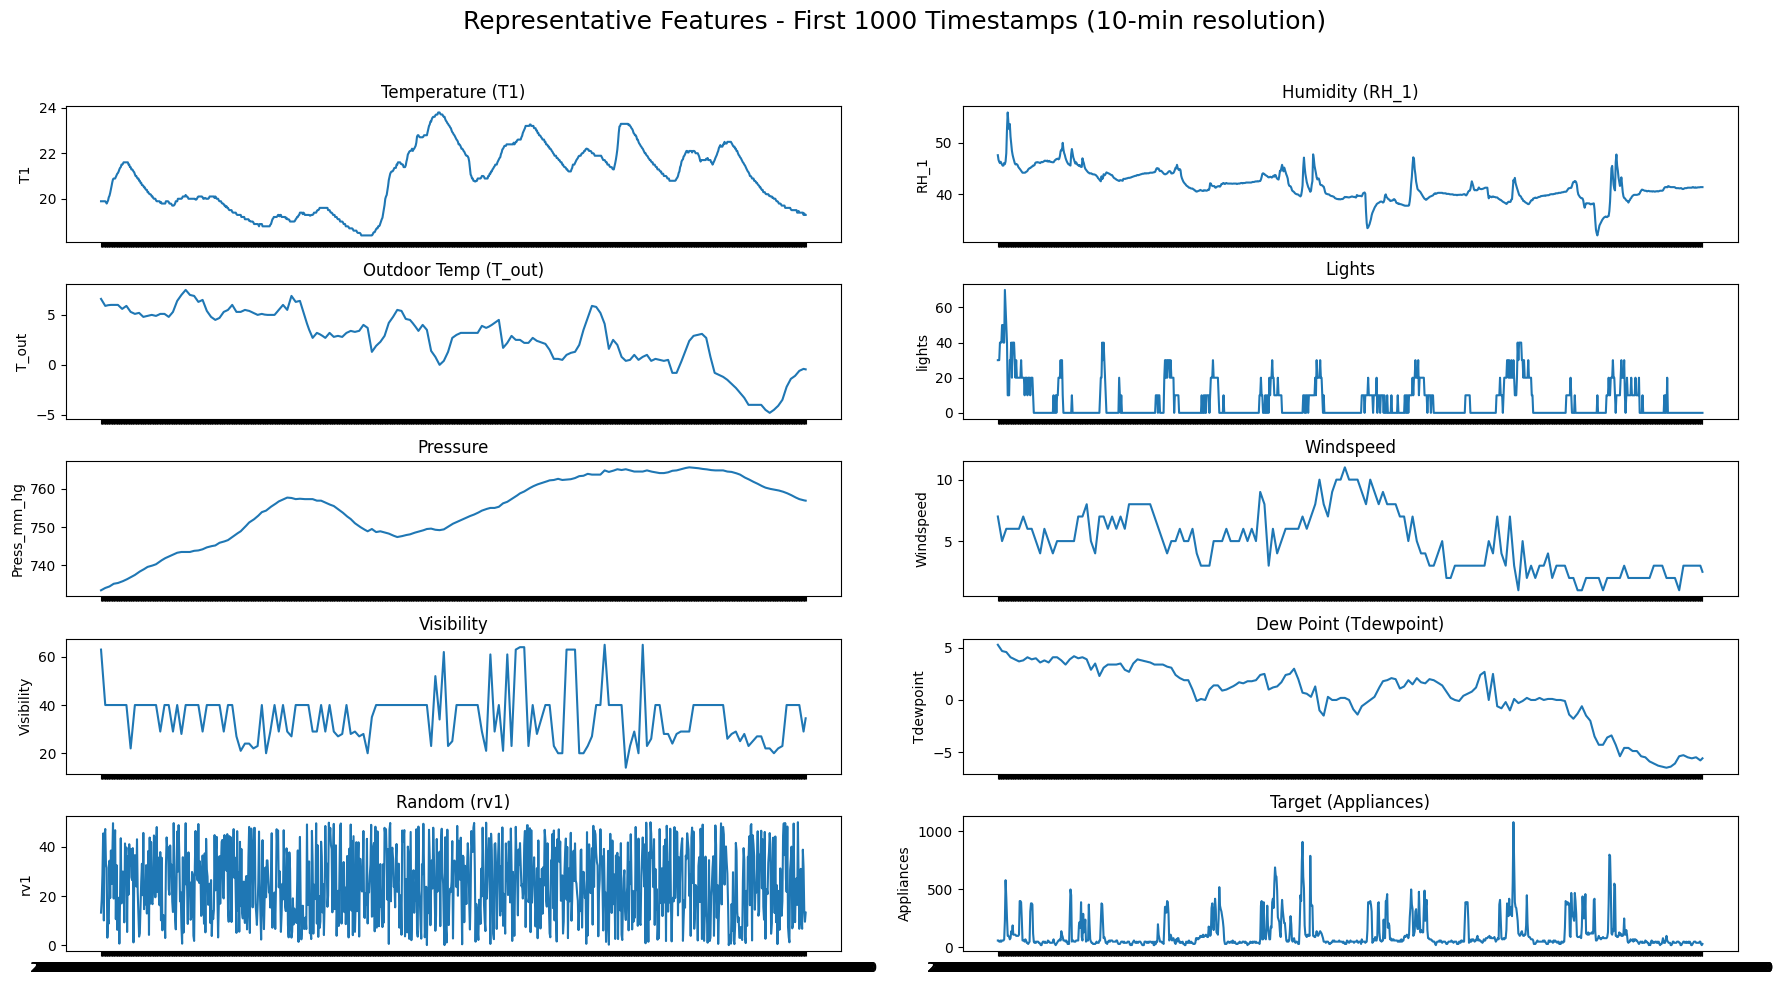

In [8]:
# Use only the first 1000 timestamps
df_subset = df.iloc[:1000]

# Select features to plot
selected_features = {
    "Temperature (T1)": "T1",
    "Humidity (RH_1)": "RH_1",
    "Outdoor Temp (T_out)": "T_out",
    "Lights": "lights",
    "Pressure": "Press_mm_hg",
    "Windspeed": "Windspeed",
    "Visibility": "Visibility",
    "Dew Point (Tdewpoint)": "Tdewpoint",
    "Random (rv1)": "rv1",
    "Target (Appliances)": "Appliances"
}

# Plot 3x4 grid
fig, axes = plt.subplots(5, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (label, col) in enumerate(selected_features.items()):
    axes[i].plot(df_subset.index, df_subset[col])
    axes[i].set_title(label)
    axes[i].set_ylabel(col)

# Hide unused subplots
for j in range(len(selected_features), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Representative Features - First 1000 Timestamps (10-min resolution)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

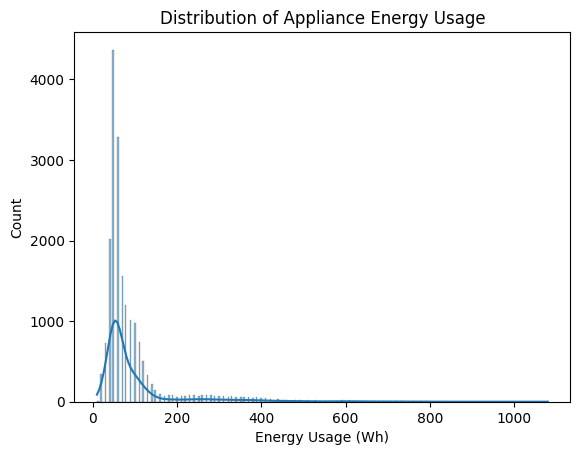

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["Appliances"], kde=True)
plt.title('Distribution of Appliance Energy Usage')
plt.xlabel('Energy Usage (Wh)')
plt.show()

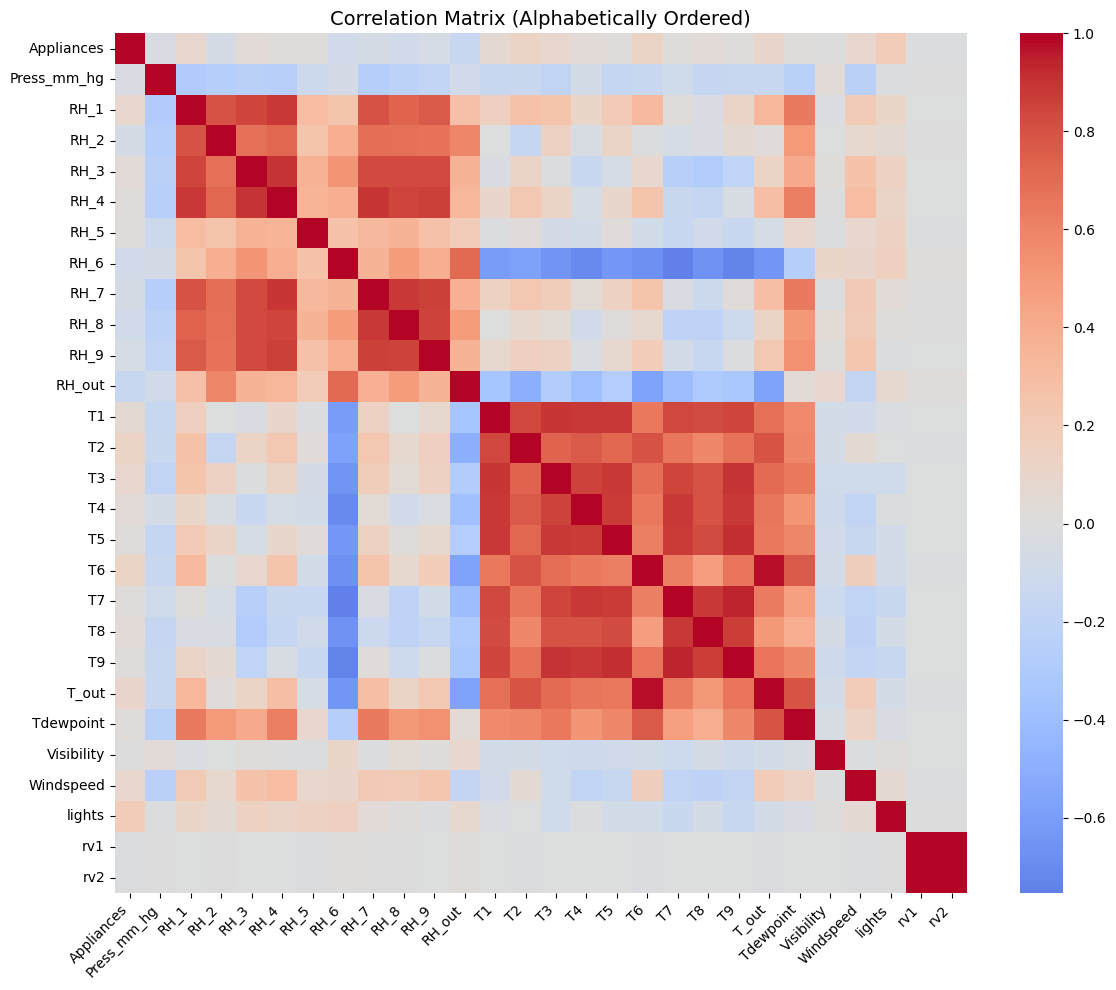

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr()

# Sort correlation matrix by alphabetical order of columns
sorted_cols = sorted(corr.columns)
corr_sorted = corr.loc[sorted_cols, sorted_cols]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_sorted, cmap='coolwarm', annot=False, center=0)
plt.title('Correlation Matrix (Alphabetically Ordered)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.flatten(), cmap='viridis', alpha=0.5)
plt.colorbar(label='Appliance Usage')
plt.title('PCA of Feature Space Colored by Target')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

NameError: name 'X' is not defined

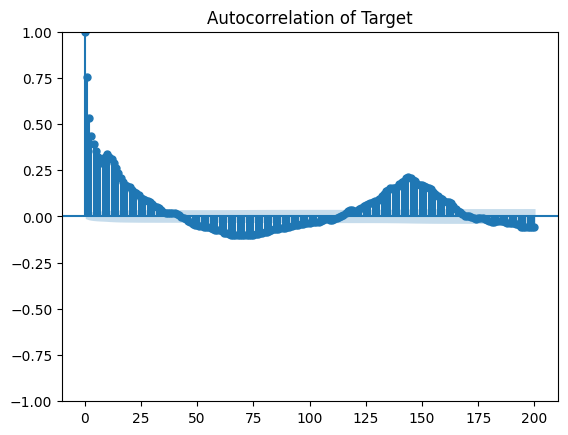

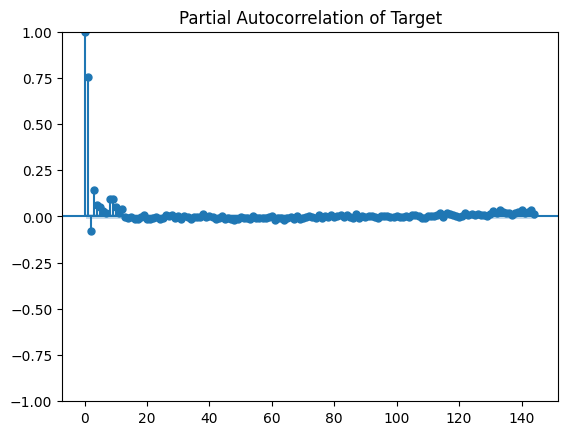

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y.squeeze(), lags=200)
plt.title("Autocorrelation of Target")
plt.show()

plot_pacf(y.squeeze(), lags=144)
plt.title("Partial Autocorrelation of Target")
plt.show()

In [22]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

sns.boxplot(x='hour', y='target', data=df)
plt.title('Energy Usage by Hour')
plt.show()

KeyError: 'date'

(19735, 28)

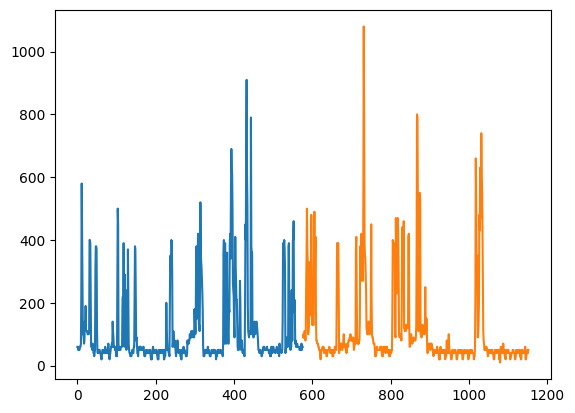

In [ ]:
plt.plot(y[:144*4])
plt.plot(y[144*4:144*8])
X.shape

## Data Cleaning

In [ ]:
# Drop the date column (non-numeric, not useful for modeling)
date = X.drop(columns=['date'])
X = X.drop(columns=['date'])

# Check for missing values or NaNs
missing_values = X.isnull().sum()
nan_values = X.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])
print("\nNaN values per column:\n", nan_values[nan_values > 0])

# If needed: drop or impute missing values (not required here if no NaNs found)
# Example (only if needed): X = X.dropna()

Missing values per column:
 Series([], dtype: int64)

NaN values per column:
 Series([], dtype: int64)


## Non-Stationary Verification

### Visual Methods

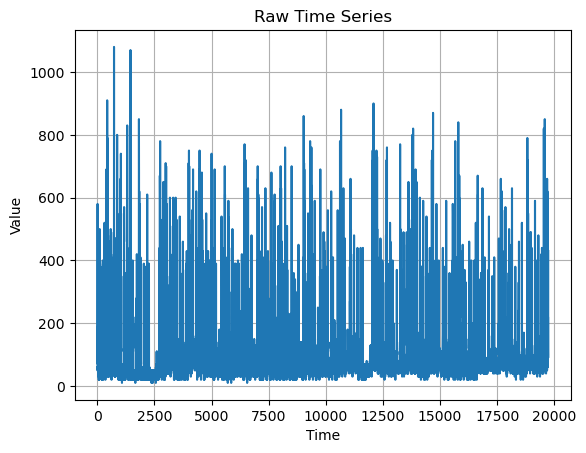

In [130]:
# Time Serie Visualization
plt.plot(y)
plt.title("Raw Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

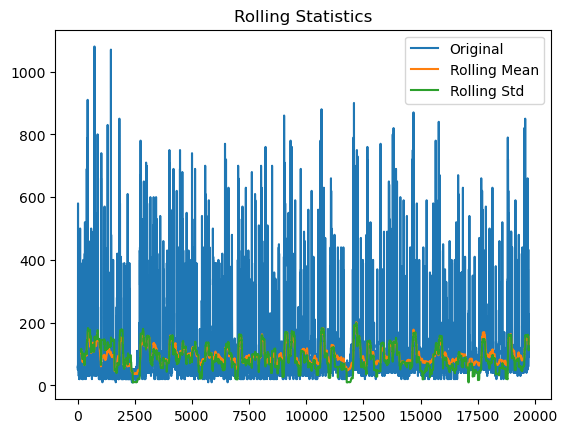

In [131]:
# Rolling Mean and Rolling Std
roll_mean = y.rolling(window=144).mean()
roll_std = y.rolling(window=144).std()

plt.plot(y, label='Original')
plt.plot(roll_mean, label='Rolling Mean')
plt.plot(roll_std, label='Rolling Std')
plt.legend()
plt.title("Rolling Statistics")
plt.show()

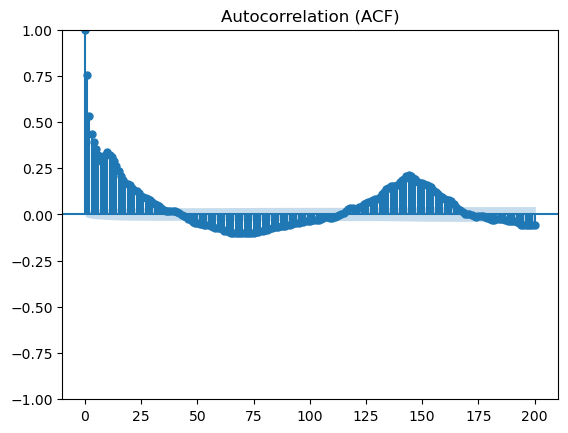

In [132]:
# Autocorrelation Plot (ACF)
# Slow decay: non-stationary
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y, lags=200)
plt.title("Autocorrelation (ACF)")
plt.show()

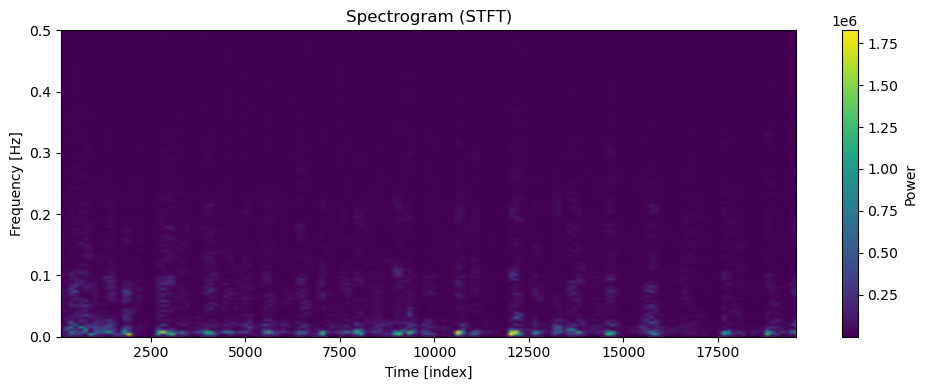

In [133]:
# Spectrogram

import matplotlib.pyplot as plt
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(np.ravel(y), fs=1.0, nperseg=256, noverlap=128)

plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [index]')
plt.title('Spectrogram (STFT)')
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

### Quantitative Tests

### ADF Test for Stationarity of Appliance Energy Usage

We applied the Augmented Dickey-Fuller (ADF) test to evaluate the stationarity of the `Appliances` energy usage time series. The test returned a **test statistic of −21.62** and a **p-value of 0.0**, well below the standard 0.05 threshold. This leads us to **reject the null hypothesis** of a unit root, indicating that the series is **statistically stationary in its mean**.

However, visual inspection reveals strong **non-constant variance**, **periodic spikes**, and possible **seasonality**, suggesting that the series may still exhibit **non-stationary behavior in higher-order moments**. Further transformations (e.g., log, differencing) or decomposition may be required before modeling.

In [15]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the target variable
adf_result = adfuller(df["Appliances"])
adf_statistic, p_value, lags, n_obs, crit_values, ic_best = adf_result

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4g}")
print(f"# Lags Used: {lags}")
print(f"# Observations: {n_obs}")
print("Critical Values:")
for k, v in crit_values.items():
    print(f"   {k}: {v:.4f}")
print(f"Best Information Criterion (IC): {ic_best:.2f}")

ADF Statistic: -21.6164
p-value: 0
# Lags Used: 11
# Observations: 19723
Critical Values:
   1%: -3.4307
   5%: -2.8617
   10%: -2.5668
Best Information Criterion (IC): 220573.75


### Seasonal Decomposition

In [27]:
from scipy.fft import fft
import numpy as np

n = len(df["Appliances"])
y_fft = fft(df["Appliances"] - np.mean(df["Appliances"]))
freqs = np.fft.fftfreq(n)
peak_freq = abs(freqs[np.argmax(np.abs(y_fft[1:n//2]))])  # avoid 0 frequency
season_length = int(round(1 / peak_freq))
print("FFT estimated season length:", season_length)


FFT estimated season length: 145


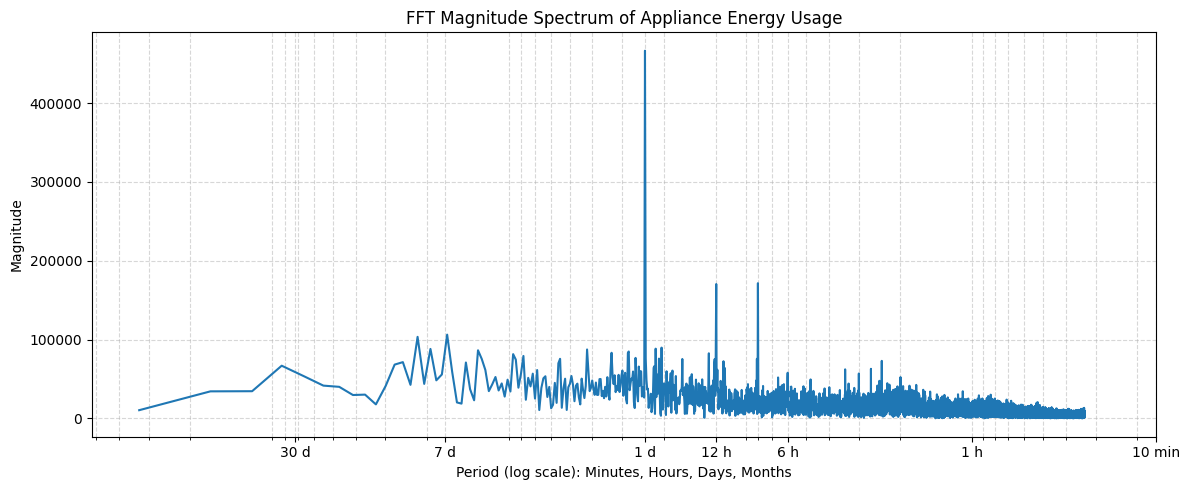

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT
y = df["Appliances"].values
y_fft = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(y), d=600)  # 10-minute interval = 600s

# Positive frequencies only
mask = frequencies > 0
freqs = frequencies[mask]
magnitudes = np.abs(y_fft)[mask]

# Convert frequency to period in seconds
periods_sec = 1 / freqs
periods_hours = periods_sec / 3600

# Plot
plt.figure(figsize=(12, 5))
plt.plot(periods_hours, magnitudes)
plt.title("FFT Magnitude Spectrum of Appliance Energy Usage")
plt.xlabel("Period (log scale): Minutes, Hours, Days, Months")
plt.ylabel("Magnitude")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid(True, which="both", ls="--", alpha=0.5)

# Custom ticks (in hours)
custom_ticks = [1/6, 1, 6, 12, 24, 24*7, 24*30]  # 10min, 1h, 6h, 12h, 1d, 7d, 30d
custom_labels = ['10 min', '1 h', '6 h', '12 h', '1 d', '7 d', '30 d']

plt.xticks(custom_ticks, custom_labels)
plt.tight_layout()
plt.show()

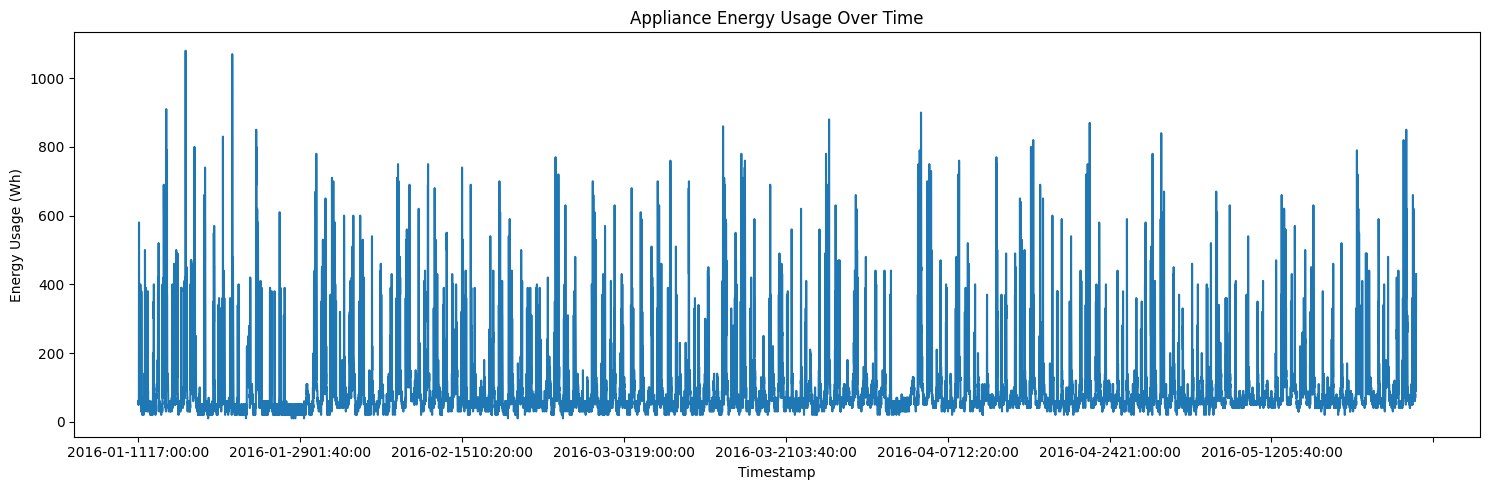

In [25]:
plt.figure(figsize=(15, 5))
df["Appliances"].plot()
plt.title("Appliance Energy Usage Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Energy Usage (Wh)")
plt.tight_layout()
plt.show()

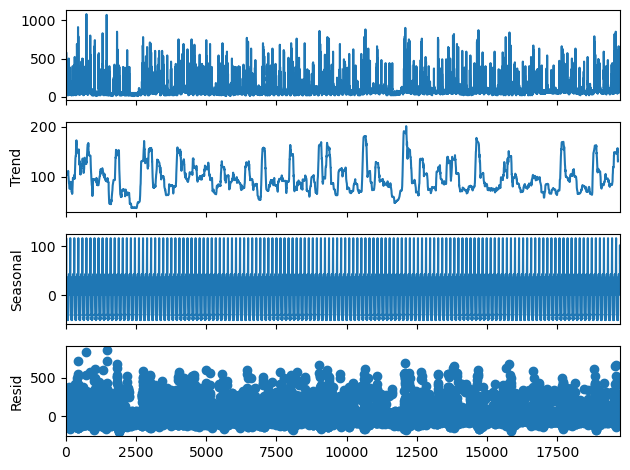

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

season_length = 144
decomp = seasonal_decompose(df["Appliances"], period=season_length, model='additive')  # adjust `season_length`
decomp.plot()
plt.show()

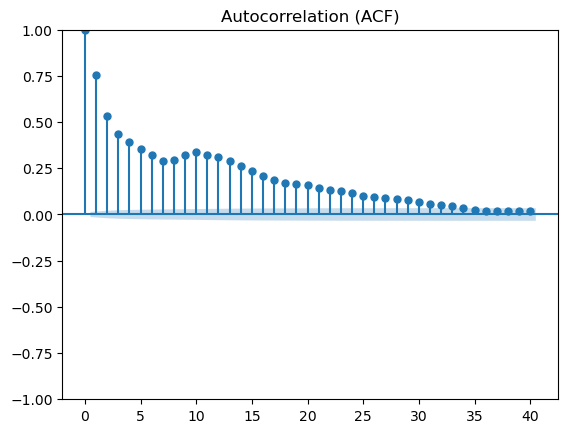

In [143]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(y, lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

In [144]:
from statsmodels.tsa.stattools import acf, pacf

acf_vals = acf(y, nlags=40)
pacf_vals = pacf(y, nlags=40)

print("ACF:", acf_vals)
print("PACF:", pacf_vals)

ACF: [1.         0.75296333 0.53395633 0.4375263  0.39093748 0.35693142
 0.32346214 0.28943524 0.29270881 0.32235675 0.33744556 0.32407483
 0.3105393  0.29019824 0.26287904 0.2371291  0.20998438 0.18458154
 0.17035818 0.16597471 0.15737135 0.14433058 0.13351677 0.12507164
 0.11394859 0.10057529 0.09209041 0.08746679 0.08510046 0.07730207
 0.06958134 0.05908652 0.05267992 0.04839332 0.03769603 0.02693328
 0.02050254 0.01706534 0.02061901 0.02092793 0.0184238 ]
PACF: [ 1.00000000e+00  7.53001488e-01 -7.62162770e-02  1.44551851e-01
  6.16455114e-02  5.27467294e-02  2.98255348e-02  1.74594321e-02
  9.50690209e-02  9.48637996e-02  5.17194001e-02  1.69513277e-02
  3.92402737e-02 -1.45904834e-03 -7.79501748e-03 -2.07264369e-03
 -1.28032968e-02 -1.22588944e-02 -1.83535040e-03  5.38651681e-03
 -1.23605786e-02 -1.37855159e-02 -7.27506058e-03 -5.04081950e-03
 -1.26103583e-02 -1.03596510e-02  5.43840478e-03  3.73030283e-03
  5.35200706e-03 -8.56843728e-03  2.21935961e-03 -1.24835885e-02
  1.701081

## Regression


In [31]:
import torch
import platform

# Device configuration for macOS Metal or CUDA
if torch.backends.mps.is_available() and platform.system() == "Darwin":
    device = torch.device("mps")  # Apple Silicon (Metal Performance Shaders)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

print(f"Using device: {device}")

Using device: mps


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

y = df['Appliances']                      
X = df.drop(columns=['Appliances'])       

# 1.4. Normalización (fit solo en train)
train_size = int(len(y)*0.8)
scaler_X = StandardScaler().fit(X.iloc[:train_size])
scaler_y = StandardScaler().fit(y.iloc[:train_size].values.reshape(-1,1))
Xs = scaler_X.transform(X)
ys = scaler_y.transform(y.values.reshape(-1,1)).flatten()

In [ ]:
import torch
from torch.utils.data import Dataset

horizon = 100 #144 100
input_len = 144*5
stride = 72

from models.seq_dataloader import SeqDataset

# Crear splits
ds = SeqDataset(Xs, ys, input_len=input_len, horizon=horizon)
n_train = int(len(ds)*0.8)
train_ds, test_ds = torch.utils.data.random_split(ds, [n_train, len(ds)-n_train])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [ ]:
# 1) LSTM
from models.train_model import fit_model

from models.lstm import LSTMForecaster
print(f"LSTM...")
lstm = LSTMForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device)
hist_l, met_l = fit_model(lstm,   train_loader, test_loader, device)

# # 2) Transformer
from models.transformer import TransfForecaster
print(f"Transformer...")
transf = TransfForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device)
hist_t, met_t = fit_model(transf, train_loader, test_loader, device)

# # 3) TCN
from models.tcn import TCNForecaster
print(f"TCN...")
tcn = TCNForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device)
hist_c, met_c = fit_model(tcn,    train_loader, test_loader, device)


LSTM...
Ep 5/200 — Loss: 0.4634
Ep 10/200 — Loss: 0.4260
Ep 15/200 — Loss: 0.4142
Ep 20/200 — Loss: 0.4050
Ep 25/200 — Loss: 0.3977
Ep 30/200 — Loss: 0.3896
Ep 35/200 — Loss: 0.3841
Ep 40/200 — Loss: 0.3753
Ep 45/200 — Loss: 0.3691
Ep 50/200 — Loss: 0.3636
Ep 55/200 — Loss: 0.3526
Ep 60/200 — Loss: 0.3445
Ep 65/200 — Loss: 0.3420
Ep 70/200 — Loss: 0.3361
Ep 75/200 — Loss: 0.3290
Ep 80/200 — Loss: 0.3231
Ep 85/200 — Loss: 0.3172
Ep 90/200 — Loss: 0.3121
Ep 95/200 — Loss: 0.3058
Ep 100/200 — Loss: 0.3024
Ep 105/200 — Loss: 0.2949
Ep 110/200 — Loss: 0.2921
Ep 115/200 — Loss: 0.2860
Ep 120/200 — Loss: 0.2960
Ep 125/200 — Loss: 0.2761
Ep 130/200 — Loss: 0.2701
Ep 135/200 — Loss: 0.2666
Ep 140/200 — Loss: 0.2622
Ep 145/200 — Loss: 0.2597
Ep 150/200 — Loss: 0.2719
Ep 155/200 — Loss: 0.2562
Ep 160/200 — Loss: 0.2529
Ep 165/200 — Loss: 0.2474
Ep 170/200 — Loss: 0.2420
Ep 175/200 — Loss: 0.2394
Ep 180/200 — Loss: 0.2376
Ep 185/200 — Loss: 0.2352
Ep 190/200 — Loss: 0.2311
Ep 195/200 — Loss: 0.229

        Modelo        MAE        RMSE
0         LSTM  54.867798  105.688914
1  Transformer  52.715614   99.436150
2          TCN  62.601974  104.782834


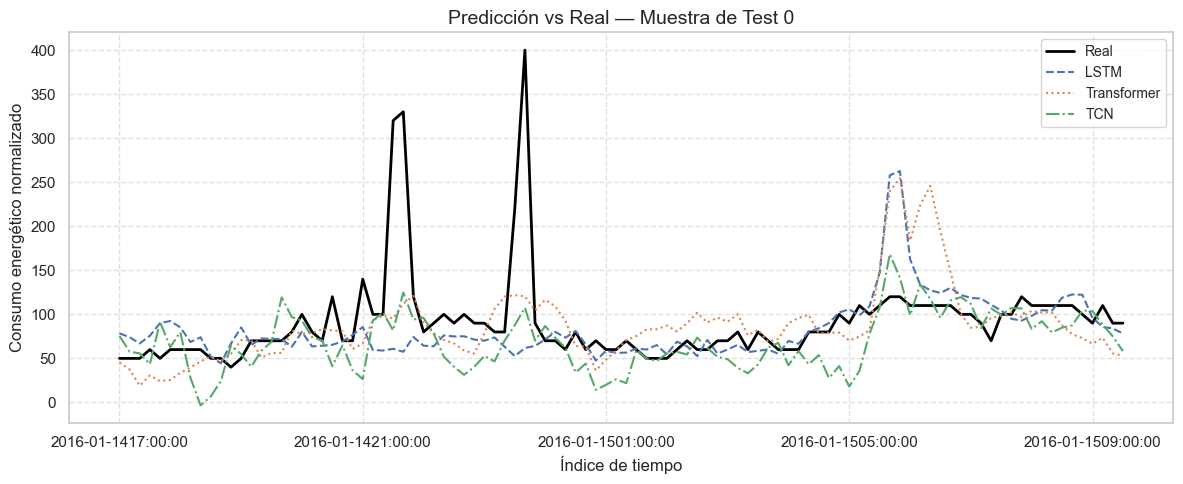

In [80]:
import matplotlib.dates as mdates

# KPI summary
df_kpi = pd.DataFrame({
    'Modelo': ['LSTM','Transformer','TCN'],
    'MAE':    [met_l['MAE'], met_t['MAE'], met_c['MAE']],
    'RMSE':   [met_l['RMSE'],met_t['RMSE'], met_c['RMSE']],
})
print(df_kpi)

test_sample = 0

# Time range for plotting
start_idx = test_sample * stride + input_len
time_range = df.index[start_idx : start_idx + horizon]

# Plot setup
plt.figure(figsize=(12, 5))
plt.plot(time_range, met_l['y_true'][test_sample], label='Real', linewidth=2, color='black')
plt.plot(time_range, met_l['y_pred'][test_sample], '--', label='LSTM', linewidth=1.5)
plt.plot(time_range, met_t['y_pred'][test_sample], ':', label='Transformer', linewidth=1.5)
plt.plot(time_range, met_c['y_pred'][test_sample], '-.', label='TCN', linewidth=1.5)

# Title and labels
plt.title(f"Predicción vs Real — Muestra de Test {test_sample}", fontsize=14)
plt.xlabel("Índice de tiempo", fontsize=12)
plt.ylabel("Consumo energético normalizado", fontsize=12)

# Reduce x-tick clutter using fixed interval
step = 24  # Every 4 hours (10-minute steps)
tick_positions = time_range[::step]
tick_labels = tick_positions.astype(str)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=0)

# Finish
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [79]:
time_range

Index(['2016-01-1417:00:00', '2016-01-1417:10:00', '2016-01-1417:20:00',
       '2016-01-1417:30:00', '2016-01-1417:40:00', '2016-01-1417:50:00',
       '2016-01-1418:00:00', '2016-01-1418:10:00', '2016-01-1418:20:00',
       '2016-01-1418:30:00', '2016-01-1418:40:00', '2016-01-1418:50:00',
       '2016-01-1419:00:00', '2016-01-1419:10:00', '2016-01-1419:20:00',
       '2016-01-1419:30:00', '2016-01-1419:40:00', '2016-01-1419:50:00',
       '2016-01-1420:00:00', '2016-01-1420:10:00', '2016-01-1420:20:00',
       '2016-01-1420:30:00', '2016-01-1420:40:00', '2016-01-1420:50:00',
       '2016-01-1421:00:00', '2016-01-1421:10:00', '2016-01-1421:20:00',
       '2016-01-1421:30:00', '2016-01-1421:40:00', '2016-01-1421:50:00',
       '2016-01-1422:00:00', '2016-01-1422:10:00', '2016-01-1422:20:00',
       '2016-01-1422:30:00', '2016-01-1422:40:00', '2016-01-1422:50:00',
       '2016-01-1423:00:00', '2016-01-1423:10:00', '2016-01-1423:20:00',
       '2016-01-1423:30:00', '2016-01-1423:40:00', 